In [1]:
import numpy as np
import sys
import torch
from functools import partial
from matplotlib import pyplot as plt
from prob_mbrl import train_regressor, losses, models
torch.set_num_threads(2)

In [2]:
# model parameters
n_layers = 4
layer_width = 200
drop_rate = 0.25
odims = 1
N_ensemble = 100
use_cuda = True

# single gaussian output model
model = models.Regressor(
    models.dropout_mlp(
        1, 2*odims, [layer_width]*n_layers,
        nonlin=torch.nn.ReLU,
        weights_initializer=partial(torch.nn.init.xavier_normal_,
                                    gain=torch.nn.init.calculate_gain('relu')),
        biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        dropout_layers=[models.CDropout(drop_rate, temperature=.1)
                        for i in range(n_layers)]),
    output_density=models.DiagGaussianDensity(odims))

# mixture density network
n_components = 5
mmodel = models.Regressor(
    models.dropout_mlp(
        1, 2*n_components*odims + n_components, [layer_width]*n_layers,
        nonlin=torch.nn.ReLU,
        weights_initializer=partial(torch.nn.init.xavier_normal_,
                                    gain=torch.nn.init.calculate_gain('relu')),
        biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        dropout_layers=[models.CDropout(drop_rate, temperature=.1)
                        for i in range(n_layers)]),
    output_density=models.MixtureDensity(odims, n_components))


# optimizer for single gaussian model
opt1 = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)

# optimizer for mixture density network
opt2 = torch.optim.Adam(mmodel.parameters(), 1e-3, amsgrad=True)

In [3]:
# create training dataset
def f(x, multimodal=False):
    k = 100
    if multimodal:
        k *= np.random.choice([-1, 1], x.shape[0])
    return k*sum([np.sin(-2*np.pi*(2*k-1)*x)/(2*k-1) for k in range(1, 3)])

train_x = np.concatenate([np.arange(-0.6,-0.25,0.01),
                          np.arange(0.1,0.25,0.01),
                          np.arange(0.65,1.0,0.01),
                         ])
train_y = f(train_x)
train_y += 0.01*np.random.randn(*train_y.shape)
X = torch.from_numpy(train_x[:, None]).float()
Y = torch.from_numpy(train_y[:, None]).float()

model.set_dataset(X, Y)
mmodel.set_dataset(X, Y)

if use_cuda and torch.cuda.is_available():
    X = X.cuda()
    Y = Y.cuda()
    model = model.cuda()
    mmodel = mmodel.cuda()

print 'Dataset size:', train_x.shape[0], 'samples'

Dataset size: 85 samples


In [4]:
train_regressor(model, iters=4000, batchsize=N_ensemble, resample=True,
                optimizer=opt1)
train_regressor(mmodel, iters=4000, batchsize=N_ensemble, resample=True,
                optimizer=opt2, log_likelihood=losses.gaussian_mixture_log_likelihood)

log-likelihood of data: 1.243315: 100%|█████████▉| 3996/4000 [01:01<00:00, 65.50it/s] 


In [5]:
# evaluate single gaussian model
test_x = np.arange(-1.0,1.5,0.005)
ret = []
#model.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float().to(model.X.device)
    outs = model(x.expand((N_ensemble, 1)), resample=False)
    y = torch.cat(outs[:2], -1)
    ret.append(y.cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2)
torch.cuda.empty_cache()
import gc
for i in range(3):
    gc.collect()

Text(0,0.5,'$f(s_t, a_t) - s_t$')

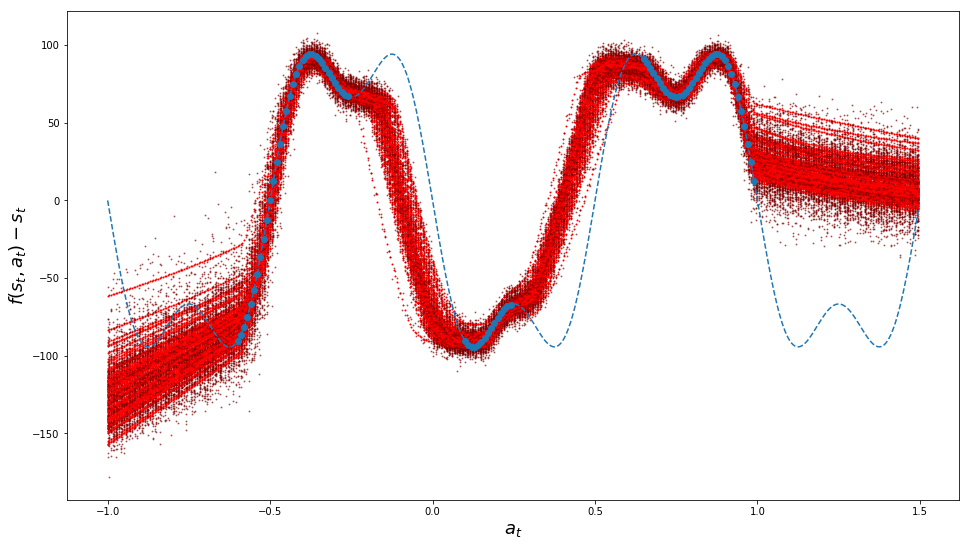

In [6]:
plt.figure(figsize=(16,9))
nc = ret.shape[-2]
colors = list(plt.cm.rainbow_r(np.linspace(0, 1, nc)))

def gaussian_sample(mu, sigma):
    z2 = np.random.randn(*mu.shape)
    return mu + z2*sigma

for i in range(len(ret)):
    m, S = ret[i, :, 0], ret[i, :, 1]
    samples = gaussian_sample(m, S)
    plt.scatter(test_x, m, c=colors[0], s=1)
    plt.scatter(test_x, samples, c=colors[0]*0.5, s=1)
    #plt.fill_between(test_x, m-S, m+S, color='red', linestyle='--', linewidth=1, alpha = 0.3)
m = ret[:, :, 0].mean(0)
S = ret[:, :, 0].std(0)
#plt.plot(test_x, m, label='nn%d' % i, color='red', linestyle='--', linewidth=2)
#plt.fill_between(test_x, m-S, m+S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.5)
#plt.fill_between(test_x, m-2*S, m+2*S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.25)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$a_t$', fontsize=18)
plt.ylabel('$f(s_t, a_t) - s_t$', fontsize=18)
#plt.legend()

In [7]:
# evaluate mixture density network
test_x = np.arange(-1.0,1.5,0.005)
ret = []
weights = []
#mmodel.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float().to(mmodel.X.device)
    outs = mmodel(x.expand((N_ensemble, 1)), resample=False)
    y = torch.cat(outs[:2], -2)
    ret.append(y.cpu().detach().numpy())
    weights.append(outs[2].cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2, 3)
weights = np.stack(weights)
weights = weights.transpose(1, 0, 2)
torch.cuda.empty_cache()
import gc
for i in range(3):
    gc.collect()

Text(0,0.5,'$f(s_t, a_t) - s_t$')

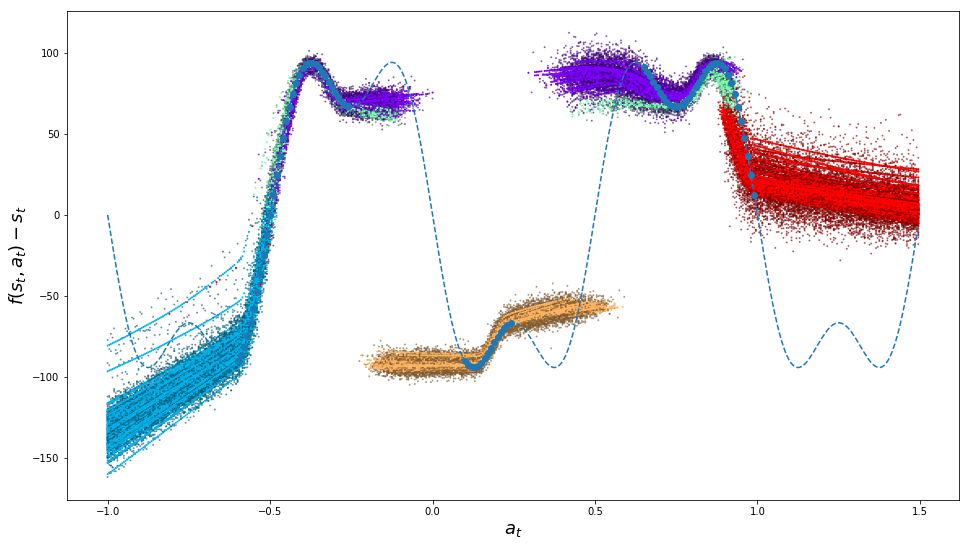

In [8]:
plt.figure(figsize=(16,9))
nc = ret.shape[-1]
colors = np.array(list(plt.cm.rainbow_r(np.linspace(0, 1, nc))))

def mixture_sample(mu, sigma, pi, colors=None, noise=True):
    z1 = np.random.rand(*pi.shape)
    k = (np.log(pi+1e-10) + z1).argmax(-1)
    idx = np.arange(len(mu))
    samples = mu[idx, k]
    if noise:
        z2 = np.random.randn(*mu.shape[:-1])
        samples += z2*sigma[idx, k]

    if colors is not None:
        return samples, colors[k]
    return samples

total_samples = []
for i in range(len(ret)):
    m, S = ret[i, :, 0, :], ret[i, :, 1, :]
    samples, c = mixture_sample(m, S, weights[i], colors)
    plt.scatter(test_x, samples, c=c*0.5, s=1)
    samples, c = mixture_sample(m, S, weights[i], colors, noise=False)
    plt.scatter(test_x, samples, c=c, s=1)
    total_samples.append(samples)
total_samples = np.array(total_samples)
m = total_samples.mean(0)
S = total_samples.std(0)
#plt.plot(test_x, m, label='nn%d' % i, color='red', linestyle='--', linewidth=2)
#plt.fill_between(test_x, m-S, m+S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.5)
#plt.fill_between(test_x, m-2*S, m+2*S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.25)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$a_t$', fontsize=18)
plt.ylabel('$f(s_t, a_t) - s_t$', fontsize=18)
#plt.legend()

In [9]:
model

Regressor(
  (model): BSequential(
    (fc0): Linear(in_features=1, out_features=200, bias=True)
    (drop0): CDropout(rate=0.0492827296257, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin0): ReLU()
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (drop1): CDropout(rate=0.0729744434357, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin1): ReLU()
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (drop2): CDropout(rate=0.0891431570053, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin2): ReLU()
    (fc3): Linear(in_features=200, out_features=200, bias=True)
    (drop3): CDropout(rate=0.030427634716, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin3): ReLU()
    (fc_out): Linear(in_features=200, out_features=2, bias=True)
  )
  (output_density): DiagGaussianDensity()
)

In [10]:
mmodel

Regressor(
  (model): BSequential(
    (fc0): Linear(in_features=1, out_features=200, bias=True)
    (drop0): CDropout(rate=0.0427501797676, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin0): ReLU()
    (fc1): Linear(in_features=200, out_features=200, bias=True)
    (drop1): CDropout(rate=0.0757004618645, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin1): ReLU()
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (drop2): CDropout(rate=0.0951456427574, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin2): ReLU()
    (fc3): Linear(in_features=200, out_features=200, bias=True)
    (drop3): CDropout(rate=0.0501961112022, temperature=0.10000000149, regularizer_scale=1.0)
    (nonlin3): ReLU()
    (fc_out): Linear(in_features=200, out_features=15, bias=True)
  )
  (output_density): MixtureDensity()
)